In [6]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import uproot
import os

timestamps = {}

for station in os.listdir('/cr/tempdata01/filip/UubRandoms/Nov2022/converted/timestamps'):
    
    start, stop = np.inf, -np.inf
    for file in np.loadtxt(f"/cr/tempdata01/filip/UubRandoms/Nov2022/converted/timestamps/{station}", usecols=[1, 2]):
        if file[0] < start: start = file[0]
        if file[1] > stop: stop = file[1]
    
    timestamps[station[:-4]] = (start, stop)

Stations = {'NuriaJr' : 56, 'Peru' : 1737, 'Granada' : 1738, 'Jaco' : 1742, 'LeQuiDon' : 1744, 'Svenja' : 1733, 'RukaMalen' : -1}
StationIDs, StationNames = list(Stations.values()), list(Stations.keys())
q_peak = {
    'Jaco' : np.array([189.4, 164.3, 158.6]),
    'Granada' : np.array([153.5, 160.6, 170]),
    'NuriaJr' : np.array([169.3, 176.9, 169.5]),
    'Svenja' : np.array([172.4, 187, 168.8]),
}

print(StationIDs)
print(StationNames)

[56, 1737, 1738, 1742, 1744, 1733, -1]
['NuriaJr', 'Peru', 'Granada', 'Jaco', 'LeQuiDon', 'Svenja', 'RukaMalen']


# Looking at Online Monitoring

In [7]:
t = [[], [], [], [], [], [], []]
r = [[], [], [], [], [], [], []]
VEMPeak = [[[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []]]


for day in [14, 15, 16, 17, 18]:

    file = uproot.open(f"/cr/tempdata01/filip/UubRandoms/__Monit/mc_2022_11_{day}_00h00.root")

    for j, station in enumerate(StationIDs):
        points = np.argwhere(file["SDMonCal/SDMonCalBranch/fLsId"].array() == station)
        points = [i for l in points for i in l]

        vem = file["SDMonCal/SDMonCalBranch/fCalibration/fCalibration.fPeak[3]"].array()[points]
        rate = file["SDMonCal/SDMonCalBranch/fCalibration/fCalibration.fT1"].array()[points]
        
        for _ in rate: r[j].append(_)

        for i in range(3):
            mask = vem[:,i] != 0
            for x in vem[:,i][mask]:
                VEMPeak[j][i].append(x)

        t[j].append(file["SDMonCal/fTime"].array()[points][mask])

for j in range(len(t)):
    t[j] = [i for l in t[j] for i in l]


NuriaJr: [156.5, 163.65, 162.7] deviation = [0.07561, 0.0749, 0.04012]
Peru: [150.3, 117.5, 153.35] 
Granada: [145.65, 156.45, 164.65] deviation = [0.05114, 0.02584, 0.03147]
Jaco: [187.0, 155.65, 144.0] deviation = [0.01267, 0.05265, 0.09206]
LeQuiDon: [40.0, 40.0, 171.5] 
Svenja: [157.9, 170.05, 150.6] deviation = [0.08411, 0.09064, 0.10782]


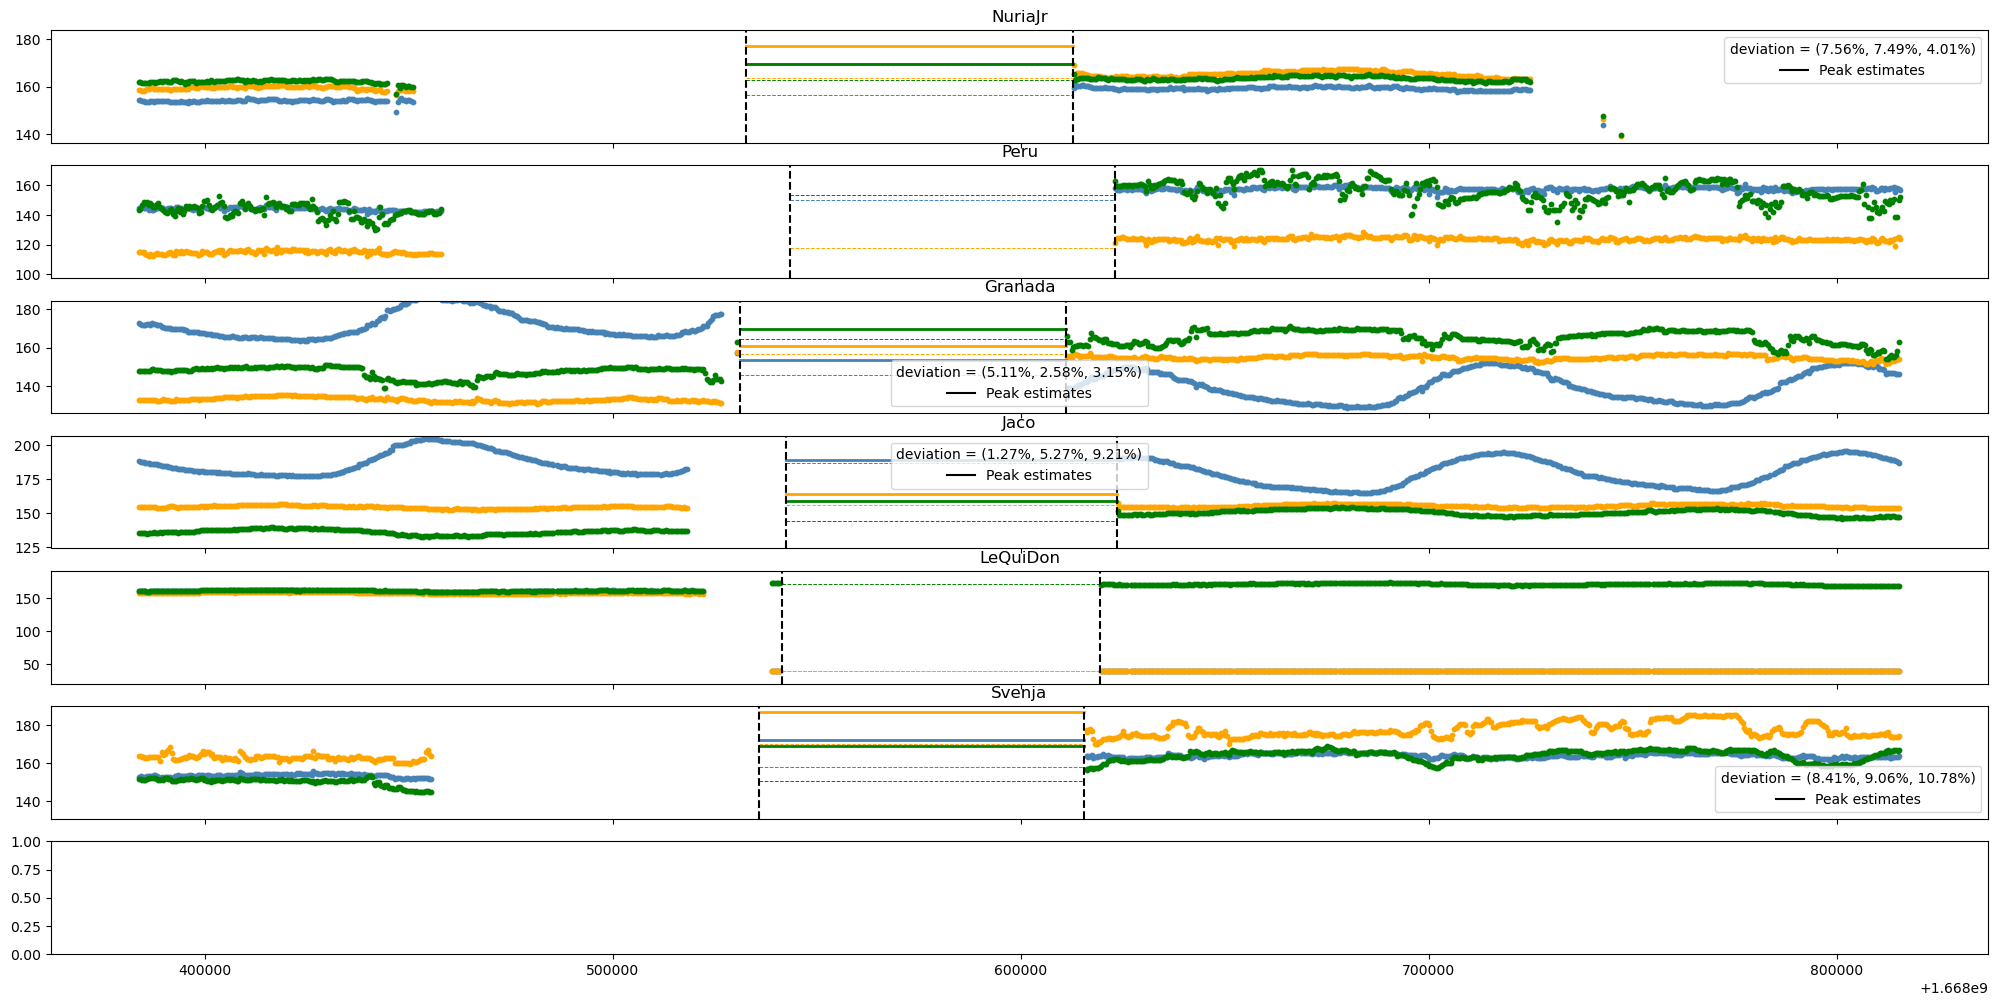

In [24]:
plt.rcParams["figure.figsize"] = [25,12]
fig, axes = plt.subplots(7,1, sharex = True)

for i, (peak, ax) in enumerate(zip(VEMPeak, axes)):
    if i == 6: continue

    station = StationNames[i]
    ax.set_title(station)

    # find first and last point 
    jump = np.argmax(np.diff(t[i]))
    peak_measurement = [np.round(0.5 * (peak[pmt][jump] + peak[pmt][jump + 1]), 2) for pmt in range(3)]
    print(f'{station}: {peak_measurement}', end=' ')

    ax.plot(timestamps[station], [peak_measurement[0] for _ in range(2)], ls = '--', lw = 0.7, c = 'steelblue')
    ax.plot(timestamps[station], [peak_measurement[1] for _ in range(2)], ls = '--', lw = 0.7, c = 'orange')
    ax.plot(timestamps[station], [peak_measurement[2] for _ in range(2)], ls = '--', lw = 0.7, c = 'green')

    try:
        ax.plot(timestamps[station], [q_peak[station][0] for _ in range(2)], c = 'steelblue', lw = 2)
        ax.plot(timestamps[station], [q_peak[station][1] for _ in range(2)], c = 'orange', lw = 2)
        ax.plot(timestamps[station], [q_peak[station][2] for _ in range(2)], c = 'green', lw = 2)
        ax.axhline(min(peak_measurement) - 30, c = 'k', label = "Peak estimates")
        deviation = [np.round((q_peak[station][i] - peak_measurement[i]) / q_peak[station][i], 5) for i in range(3)]
        ax.legend(title = f'deviation = ({deviation[0] * 100:.2f}%, {deviation[1]*100:.2f}%, {deviation[2]*100:.2f}%)')
        print(f'{deviation = }')
    except KeyError: print('')

    ax.set_ylim(min(peak_measurement) - 20, max(peak_measurement) + 20)

    ax.scatter(t[i], peak[0], s = 10, c = 'steelblue')
    ax.scatter(t[i], peak[1], s = 10, c = 'orange')
    ax.scatter(t[i], peak[2], s = 10, c = 'green')
    ax.axvline(timestamps[station][0], c = "k", ls = '--')
    ax.axvline(timestamps[station][1], c = "k", ls = '--')

    # print(f"{station}: q_peak online = ({np.mean(peak[0]):.1f}, {np.mean(peak[1]):.1f}, {np.mean(peak[2]):.1f})")



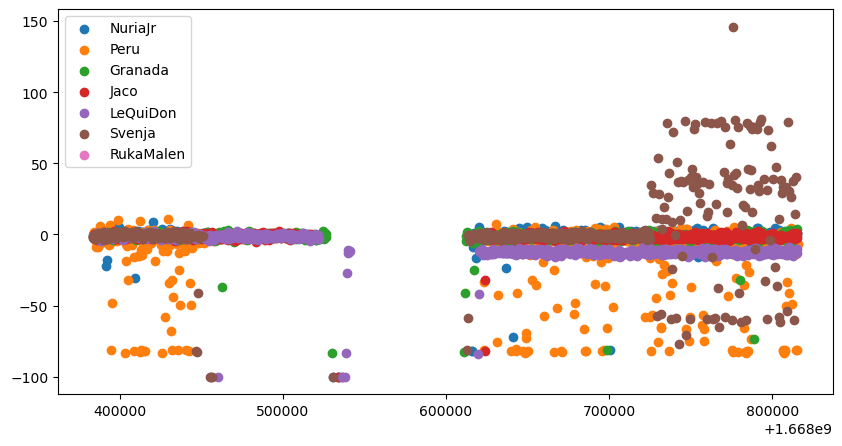

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
for i in range(len(r)):
    plt.scatter(t[i], np.array(r[i]) / 61 - 100, label = ["NuriaJr", "Peru", "Granada", "Jaco", "LeQuiDon", "Svenja", 'RukaMalen'][i])

plt.legend()

# Looking at the production data (= recostructed events)

In [ ]:
# Find out if tanks in question participated in any events
for day in [14, 15, 16, 17]:
    file = uproot.open(f"/cr/tempdata01/filip/iRODS/MonitoringData/SD_2022_11_{day}_adst.root")
    for i, event in enumerate(file["recData/event./event.fSDEvent/event.fSDEvent.fStations/event.fSDEvent.fStations.fId"].array()):
        if set(event).intersection(StationIDs): print(event)

In [ ]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = [40, 20]

for i, (station, (start, stop)) in enumerate(timestamps.items()):
    plt.axvline(dt.datetime.fromtimestamp(start), ls = '--', lw = 0.8, color = cycle[i], label=station)
    plt.axvline(dt.datetime.fromtimestamp(stop), ls = '--', lw = 0.8, color = cycle[i])

    print(len(t), len(VEMPeak[i][0]))

    plt.plot(t[i], VEMPeak[i][0], ls="solid", color = cycle[i])
    plt.plot(t[i], VEMPeak[i][1], ls="dashed", color = cycle[i])
    plt.plot(t[i], VEMPeak[i][2], ls="dotted", color = cycle[i])

print("Start:", dt.datetime.fromtimestamp(min([i[0] for i in timestamps.values()])))
print("Stop :", dt.datetime.fromtimestamp(max([i[1] for i in timestamps.values()])))

#_ = plt.xlim(dt.datetime.fromtimestamp(min([i[0] for i in timestamps.values()]) - 3600), dt.datetime.fromtimestamp(max([i[1] for i in timestamps.values()]) + 3600))

plt.legend()

# Looking at all T3s, maybe something is appearing there?

In [ ]:
# Find out if tanks in question participated in any events
for day in [15, 16]:
    file = uproot.open(f"/cr/tempdata01/filip/iRODS/MonitoringData/ad_2022_11_{day}_12h00.root")

    for item in file.keys():
        if 'Sd-only' in item:
            print(item.__dir__())

            break
    
    #for key, val in file.items():
    #    print(val)

    #for i, event in enumerate(file["recData/event./event.fSDEvent/event.fSDEvent.fStations/event.fSDEvent.fStations.fId"].array()):
    #   if set(event).intersection(StationIDs): print(event)

    break